# Project 5 - Vehicle Detection and Tracking
## General Project Pipeline
1. Feature extraction and experimentation
2. Choose and train a classifier
3. Implement sliding window technique to search for vehicles on each frame
4. Implement pipeline on video and implement tracking

## Feature Extraction
### Feature Extraction Steps:
For this project, HOG is used as primary features to be extracted.
1. Read in data
2. Use alogrithm provided in lesson to extract HOG
3. Store data into array

#### Read in Data

In [1]:
#imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
import os
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from scipy.ndimage.measurements import label 

C:\Users\felix.ding\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#read in data and create appropriate labels
#obtain training data from each subfolders
car_folders = glob.glob('Train_data/vehicles/*')
noncar_folders = glob.glob('Train_data/non-vehicles/*')
car_imgs = []
noncar_imgs = []
for folder in car_folders:
    filenames = glob.glob(folder+'/*.png')
    car_imgs +=  filenames
for folder in noncar_folders:
    filenames = glob.glob(folder+'/*.png')
    noncar_imgs += filenames
print('number of car imgs: ' + str(len(car_imgs)))
print('number of noncar imgs: ' + str(len(noncar_imgs)))

number of car imgs: 8792
number of noncar imgs: 8968


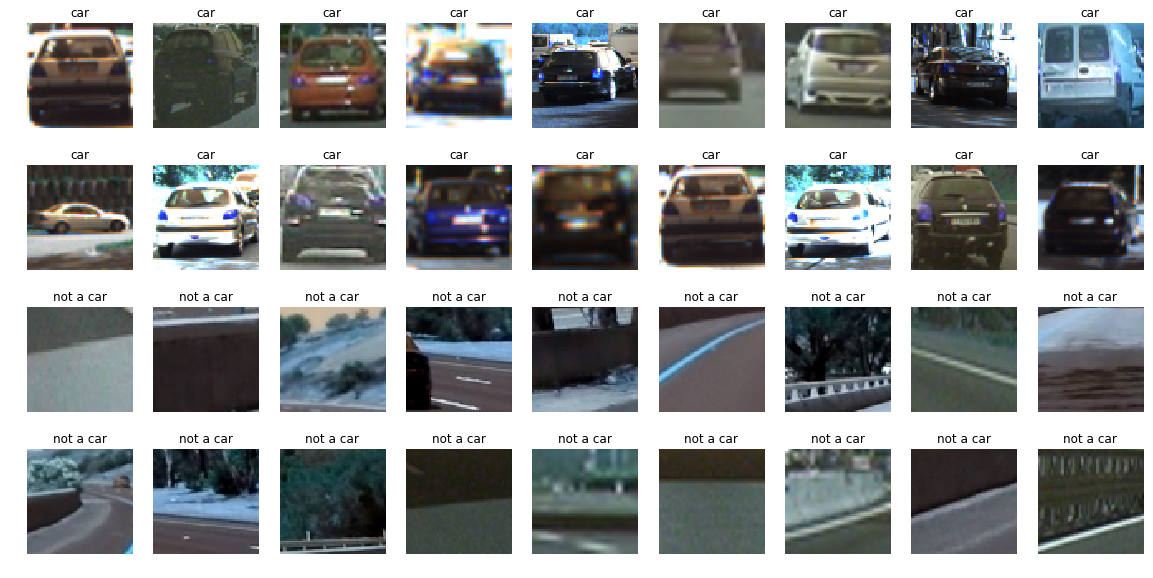

In [3]:
#sample first 18 of each car and non car to visualize
fig, ax = plt.subplots(4,9,figsize=(20,10))
rand = np.random.randint(0,len(car_imgs)-1,size=(18,))
for i in range(len(rand)):
    car_sample = cv2.imread(car_imgs[rand[i]])
    ax.flat[i].imshow(car_sample)
    ax.flat[i].axis('off')
    ax.flat[i].set_title(label='car',loc='center')
for i in range(len(rand)):
    noncar_sample = cv2.imread(noncar_imgs[rand[i]])
    ax.flat[len(rand)+i].imshow(noncar_sample)
    ax.flat[len(rand)+i].axis('off')
    ax.flat[len(rand)+i].set_title(label='not a car',loc='center')

#### Use algorithm provided to find HOG from images

In [4]:
# define hog finder
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell),
                                  cells_per_block=(cell_per_block,cell_per_block), block_norm='L2-Hys',
                                  transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell), 
                       cells_per_block=(cell_per_block,cell_per_block), block_norm='L2-Hys',
                       transform_sqrt=False, visualise=vis, feature_vector=feature_vec)
    return features

Test and visualize get hog features functions using one sample image

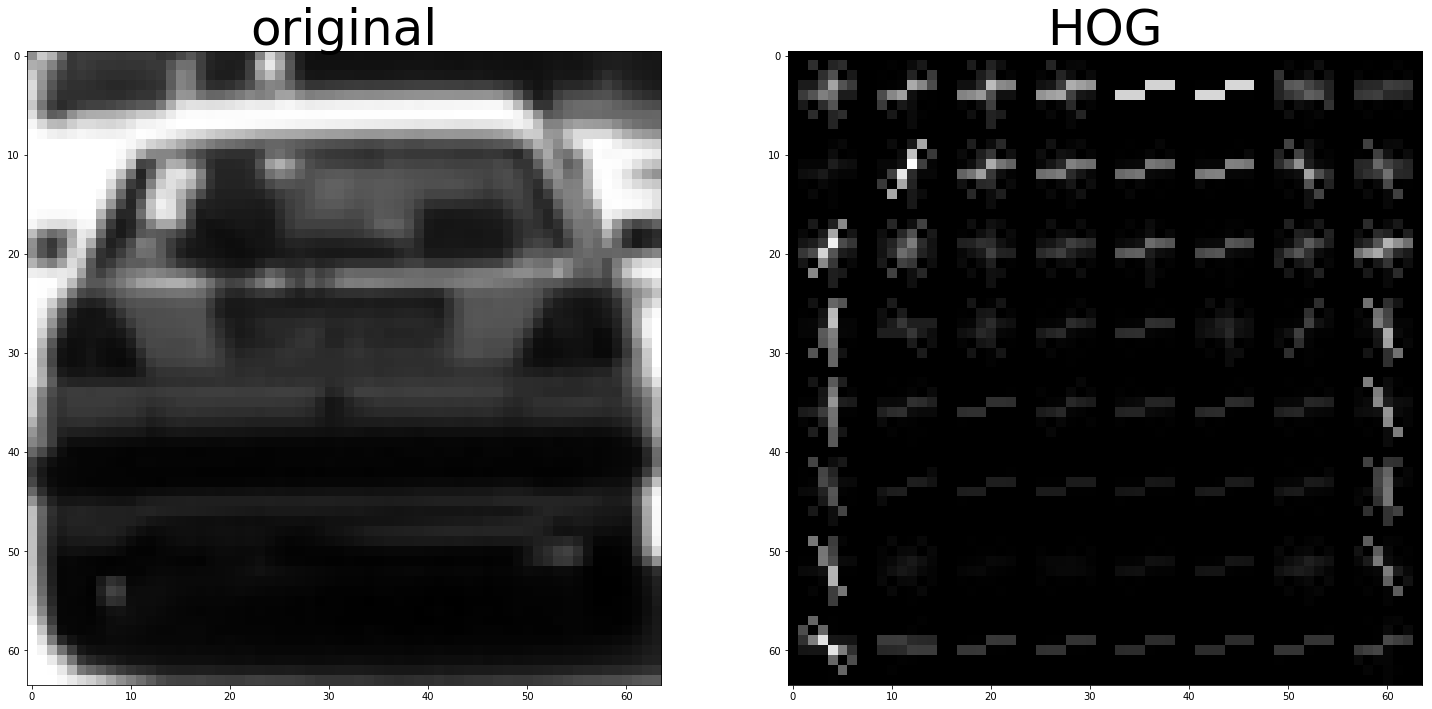

In [5]:
img = mpimg.imread(car_imgs[rand[0]])
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
test_features,hog_image = get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
fig, ax = plt.subplots(1,2,figsize=(25,25))
ax.flat[0].imshow(img, cmap='gray')
ax.flat[0].set_title('original',fontsize=50)
ax.flat[1].imshow(hog_image, cmap='gray')
ax.flat[1].set_title('HOG',fontsize=50)

We probably do not need all the channels to make a distinctive set of data. We shall now explore which color space is the best. Since we do not have a definitive metrics with which to judge the performance, we shall use visual.

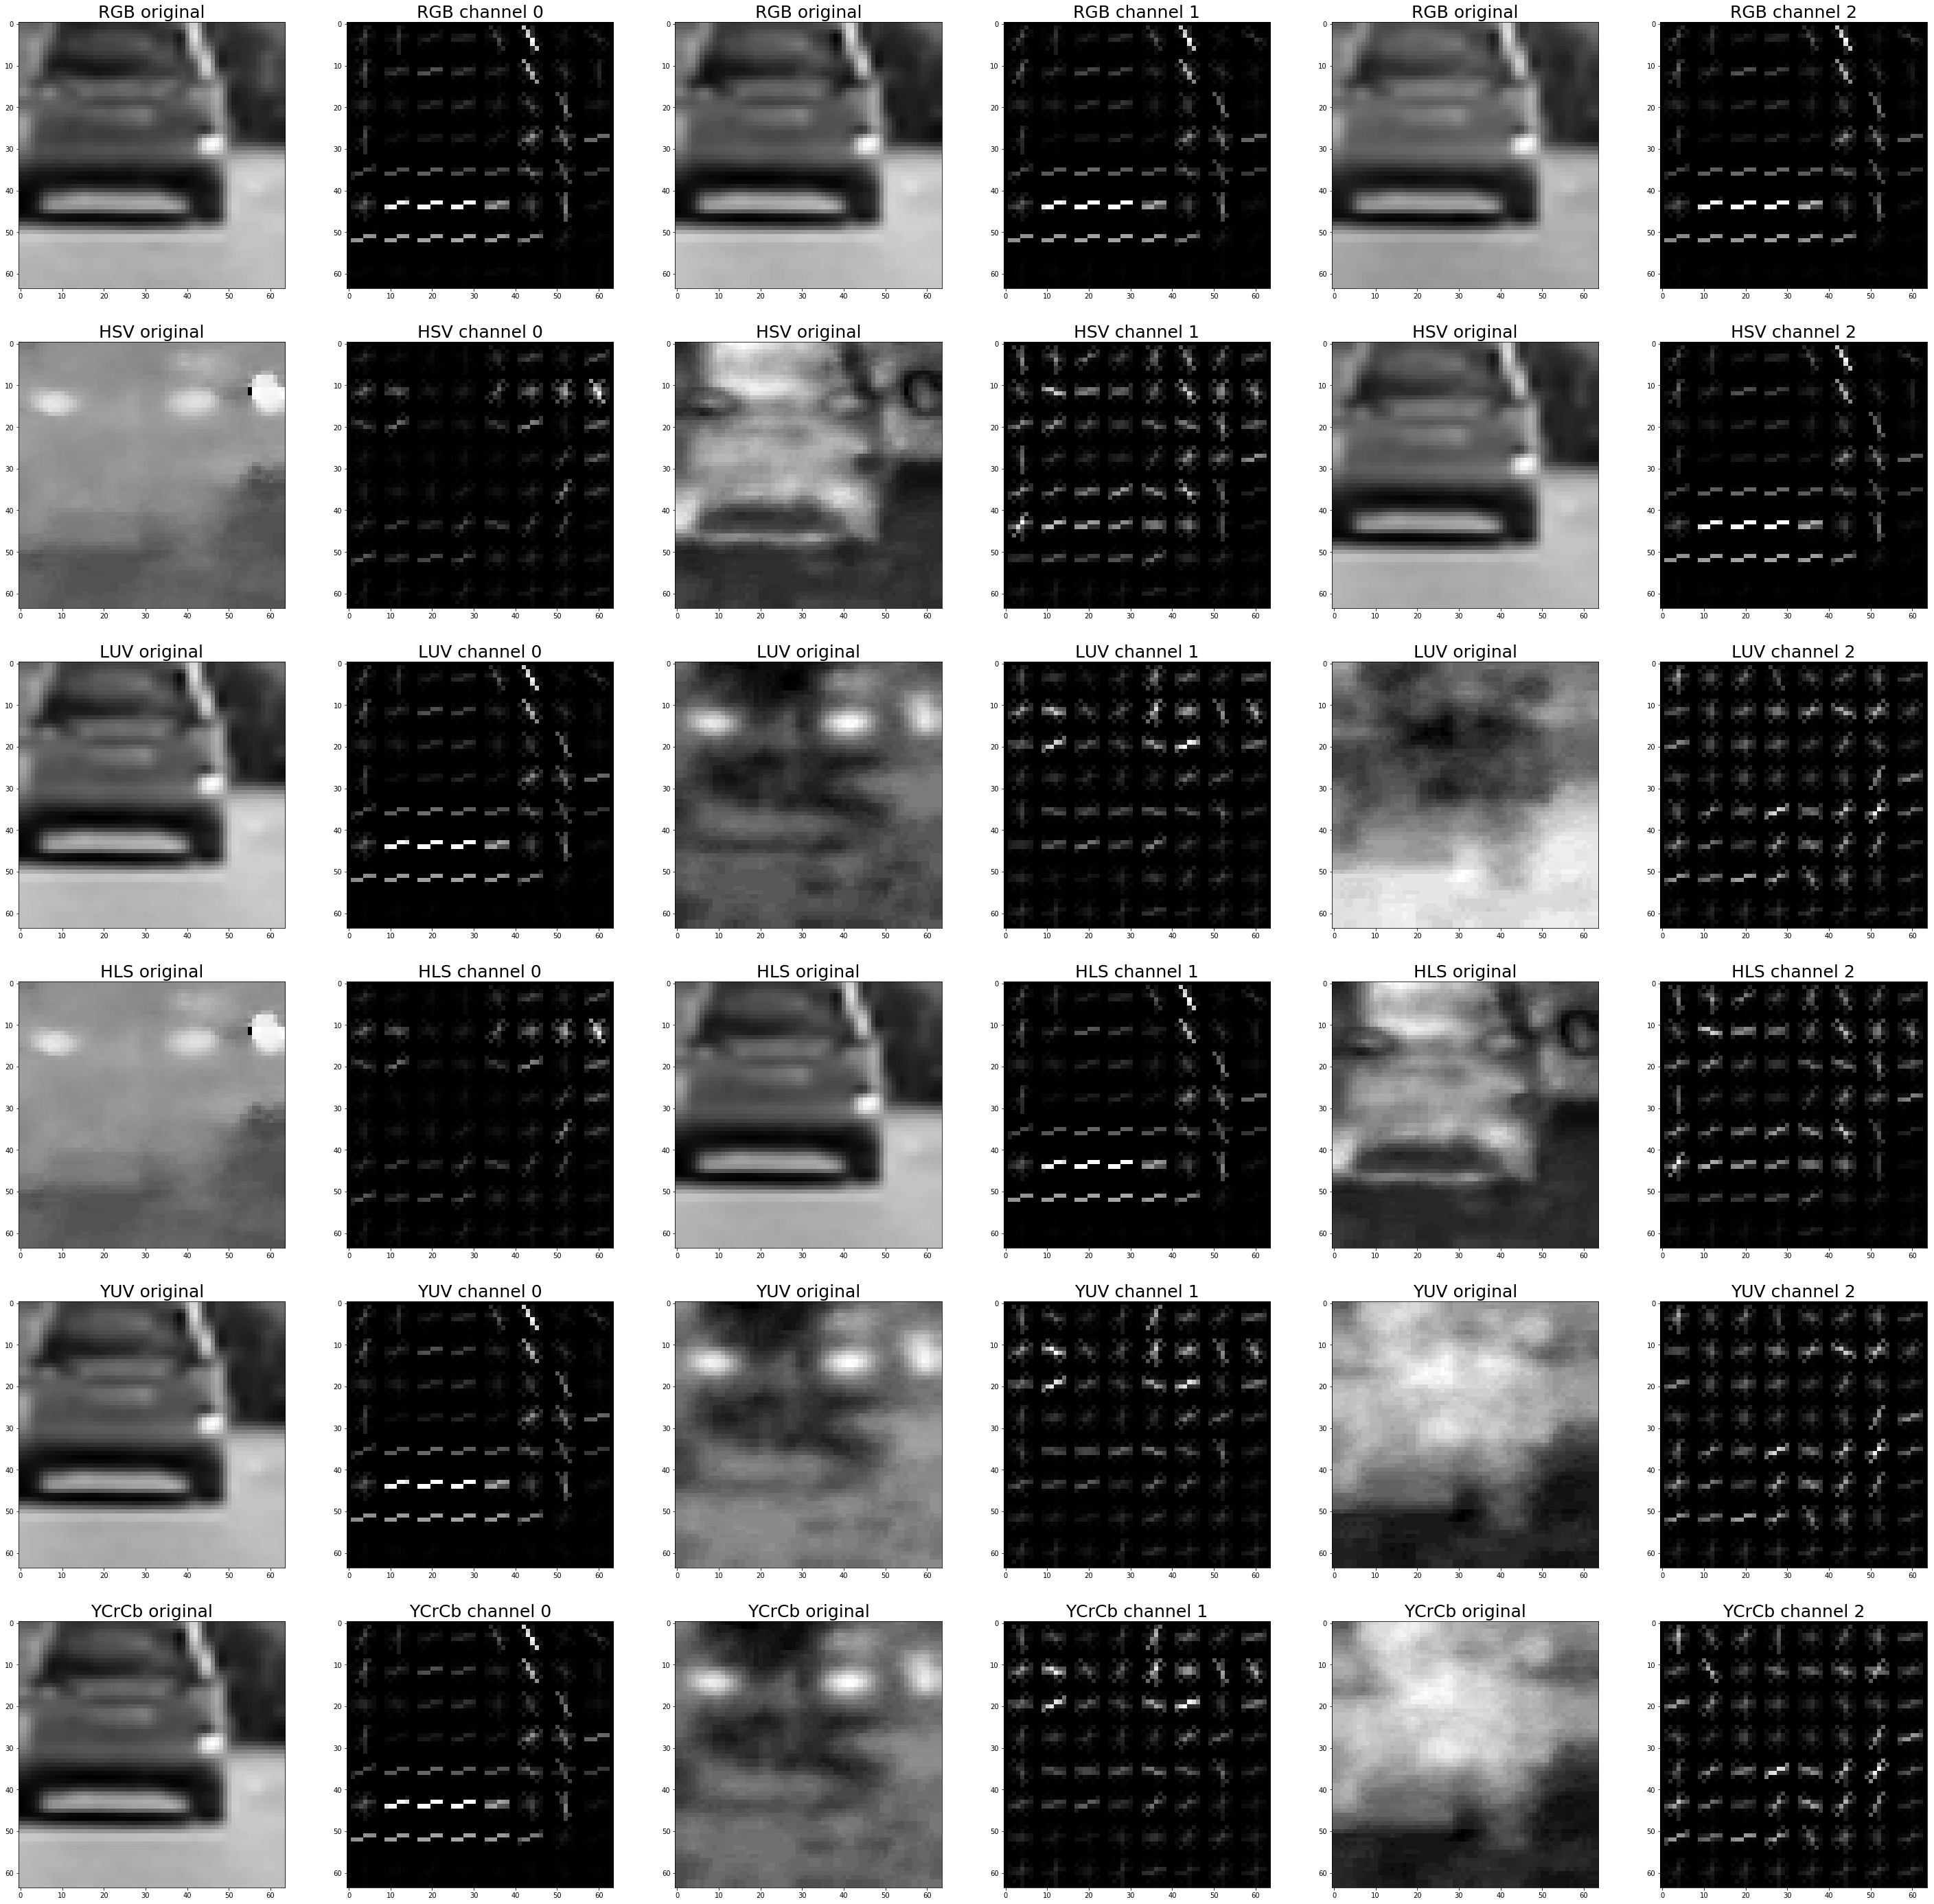

In [6]:
RGB = mpimg.imread(car_imgs[rand[5]])
HSV = cv2.cvtColor(RGB, cv2.COLOR_RGB2HSV)
LUV = cv2.cvtColor(RGB, cv2.COLOR_RGB2LUV)
HLS = cv2.cvtColor(RGB, cv2.COLOR_RGB2HLS)
YUV = cv2.cvtColor(RGB, cv2.COLOR_RGB2YUV)
YCrCb = cv2.cvtColor(RGB, cv2.COLOR_RGB2YCrCb)
cspace = [RGB, HSV, LUV, HLS, YUV, YCrCb]
cspace_names = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

fig, ax = plt.subplots(6,6,figsize=(50,50))
i=0
for img in cspace:
    test_features_0,hog_image_0 = get_hog_features(img[:,:,0], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    test_features_1,hog_image_1 = get_hog_features(img[:,:,1], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    test_features_2,hog_image_2 = get_hog_features(img[:,:,2], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    ax[i,0].imshow(img[:,:,0], cmap='gray')
    ax[i,0].set_title(cspace_names[i]+' original',fontsize=25)
    ax[i,1].imshow(hog_image_0, cmap='gray')
    ax[i,1].set_title(cspace_names[i]+' channel 0',fontsize=25)
    ax[i,2].imshow(img[:,:,1], cmap='gray')
    ax[i,2].set_title(cspace_names[i]+' original',fontsize=25)
    ax[i,3].imshow(hog_image_1, cmap='gray')
    ax[i,3].set_title(cspace_names[i]+' channel 1',fontsize=25)
    ax[i,4].imshow(img[:,:,2], cmap='gray')
    ax[i,4].set_title(cspace_names[i]+' original',fontsize=25)
    ax[i,5].imshow(hog_image_2, cmap='gray')
    ax[i,5].set_title(cspace_names[i]+' channel 2',fontsize=25)
    i += 1

It can be seen that there are a couple of options that can be ruled out immediately. These are the options that do not produce anything that resembles what is in the original image. These are:
* LUV channel 1
* LUV channel 2

Next, we eliminate those which do not produce a HOG that captures enough details or those which do not capture the correct direction of gradient that resembles the shape of the car:
* RGB channel 0
* HSV channel 0
* HSV channel 1
* HLS channel 0
* HLS channel 2
* YUV channel 1
* YUV channel 2
* YCrCb channel 1
* YCrCb channel 2

This leaves us with:
* RBG 1 and 2
* HSV 2
* LUV 0
* HLS 1
* YUV 0
* YCrCb 0

In [7]:
# define function to preprocess the image before using the hog function
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
    
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, 
                                                     pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        features.append(hog_features)
    return features 

Testing Extract Features Functions

In [148]:
# choose 200 images
sample_number = 200
car_features = extract_features(car_imgs, cspace='LUV', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0)
noncar_features = extract_features(noncar_imgs, cspace='LUV', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0)
print(len(car_features))
print(len(noncar_features))

8792
8968


## Choose and Train a Classifier
### Steps to choosing and training a classifier:
1. Create labels
2. Preprocess data
3. Determine a combination of hyperparameters and optimize
4. Train

Create labels

In [152]:
# create labels for the two sets of data
y = np.hstack((np.ones(len(car_imgs)),np.zeros(len(noncar_imgs))))

# create array stack of feature vectors
X = np.vstack((car_features,noncar_features)).astype(np.float64)

Preprocess data. This includes splitting, followed by scaling. 

In [153]:
# Split data
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Scale data
X_scaler = StandardScaler().fit(X_train)
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

In [297]:
print(X_train.shape)

(14208, 1764)


Parameter Tuning using Scikit-learn Cross Validation.
The classifier chosen is SVM. 
There are three main parameters to tune for SVM:
1. Gamma: defines how far the influence of a single training example reaches (low value - far reaching, high value - close)
2. C: defines the tradeoff between smoothness of the decision boundary and the number of sample
3. Kernel: increase of input space to achieve a more linear separable data

In [161]:
parameters = {'kernel':('linear','rbf'), 'C':[1,5,10]}
svr = svm.SVC()
clf = GridSearchCV(svr,parameters)
clf.fit(scaled_X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1, 5, 10], 'kernel': ('linear', 'rbf')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [164]:
# verifying classifier accuracy
y_pred_test = clf.predict(scaled_X_test)
accuracy = accuracy_score(y_test, y_pred_test)
print('the classifier accuracy is: ', accuracy)

the classifier accuracy is:  0.9479166666666666


In [253]:
# saving the classifier
f = open('trained_clf.p', 'wb')
pickle.dump(clf, f)
f.close()

95% accuracy may not be enough for this exercise (as learned previously from traffic sign identification project). As an attempt to improve this. The following approach is taken:
* Use a different color space for data prep
* Use all channel to increase data space
* Alter/increase the number of gradient directions in the HOG

In [8]:
# preparing a second set of data
car_features_2 = extract_features(car_imgs, cspace='YUV', orient=11, pix_per_cell=16, cell_per_block=2, hog_channel='ALL')
noncar_features_2 = extract_features(noncar_imgs, cspace='YUV', orient=11, pix_per_cell=16, cell_per_block=2, hog_channel='ALL')
print(len(car_features_2))
print(len(noncar_features_2))

8792
8968


In [9]:
# create labels for the two sets of data
y = np.hstack((np.ones(len(car_imgs)),np.zeros(len(noncar_imgs))))
# create array stack of feature vectors
X = np.vstack((car_features_2,noncar_features_2)).astype(np.float64)

# Split data
rand_state = np.random.randint(0, 100)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Scale data
X_scaler_2 = StandardScaler().fit(X_train_2)
scaled_X_train = X_scaler_2.transform(X_train_2)
scaled_X_test = X_scaler_2.transform(X_test_2)

In [50]:
# training a secondary classifier (shall be named clf2, using the optimized parameter tuned above)
clf2 = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
clf2.fit(scaled_X_train, y_train_2)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
# testing for accuracy
y_pred_test = clf2.predict(scaled_X_test)
accuracy = accuracy_score(y_test_2, y_pred_test)
print('the classifier accuracy is: ', accuracy)

the classifier accuracy is:  0.9845157657657657


As shown above, the secondary classifier has a much higher accuracy. Therefore, the secondary classifier should be used instead.

In [12]:
# saving the secondary classifier
f = open('trained_clf2.p', 'wb')
pickle.dump(clf2, f)
f.close()

## Implement a Sliding Window Technique
### Steps to implementing the sliding window technique
1. Define start stop position for x and y for area of search
2. Define the sizes with which the windows will be created
3. Define overlap percentage for sliding window
4. Combine the detection with sliding window
5. Heat map to filter out false positive

In [12]:
# define sliding window function. This function returns a list of rectangle corner coordinates
def slide_window(img, x_start_stop=[None,None], y_start_stop=[None,None], xy_window=(64,64), xy_overlap=(0.5,0.5)):
    # process search area
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # define area
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # define number of window positions
    nx_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    nx_buffer = np.int(xy_window[0]*xy_overlap[0])
    ny_buffer = np.int(xy_window[1]*xy_overlap[1])
    nx_window = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_window = np.int((yspan-ny_buffer)/nx_pix_per_step)
    # define end points of rectangles
    window_list = []
    # cycle through every window position
    for ys in range(ny_window):
        for xs in range(nx_window):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endx = startx + xy_window[0]
            endy = starty + xy_window[1]
            window_list.append(((startx,starty),(endx,endy)))
    return window_list

In [13]:
# define a function that draws rectangle
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

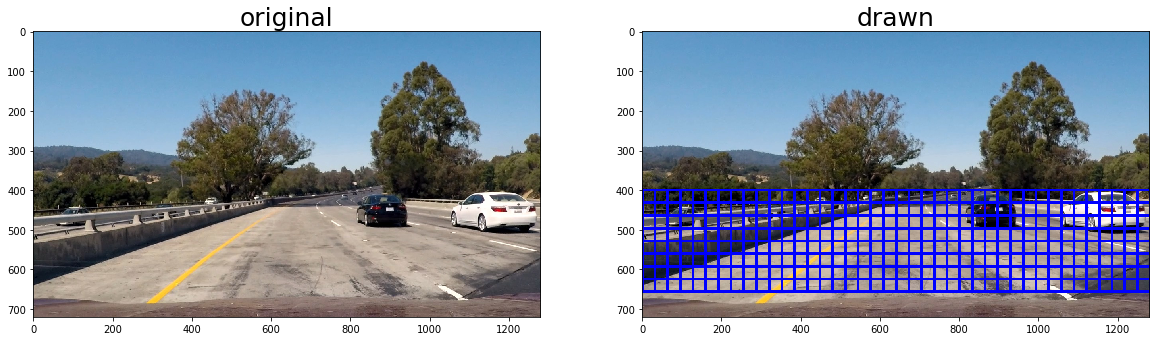

In [14]:
# testing the two functions together
img_test = mpimg.imread('test_images/test1.jpg')
y_start_stop = [400, 670]
xy_window = ()
window_test = slide_window(img_test,y_start_stop=y_start_stop)
output_test = draw_boxes(img_test, window_test)
fig, ax = plt.subplots(1,2,figsize=(20,20))
ax.flat[0].imshow(img_test)
ax.flat[0].set_title('original',fontsize=25)
ax.flat[1].imshow(output_test)
ax.flat[1].set_title('drawn',fontsize=25)

### Combine object detection with sliding window

In [15]:
# first, we need to redefine the feature extraction function so that it finds features from one image:
def single_img_features(img, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    image = img.astype(np.float32)/255
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)

    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], orient, 
                                                 pix_per_cell, cell_per_block, vis=False, feature_vec=False))
        hog_features = np.ravel(hog_features)
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                        pix_per_cell, cell_per_block, vis=False, feature_vec=False)

    return hog_features

In [16]:
# define an a still image pipeline for finding cars
def find_cars(img, start=400, stop=650, scale=1.0, X_scaler=X_scaler_2, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, cspace='LUV'):
    image = img.astype(np.float32)/255
    image = image[start:stop,:,:]
    rectangles = []
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)
        
    # rescale
    if scale != 1:
        imshape = feature_image.shape
        feature_image = cv2.resize(feature_image, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    if hog_channel == 'ALL':
        ch1 = feature_image[:,:,0]
        ch2 = feature_image[:,:,1]
        ch3 = feature_image[:,:,2]
    else:
        ch1 = feature_image[:,:,hog_channel]
        
    # calculate position related parameters
    # number of cell positions in the area of interest
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    
    window = 64
    # number of cell positions in a window
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2
    # number of window position in the area of interest
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # computing hog for the area of interest
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    else:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    # extract hog features for individual window
    # and classify once obtained
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1,-1)
            else:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = hog_feat1.reshape(1,-1)
            #return hog_features.shape
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_features = X_scaler.transform(hog_features)
            test_prediction = clf2.predict(test_features)
            
            # test classification output:
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+start),(xbox_left+win_draw,ytop_draw+win_draw+start)))
    
    return rectangles

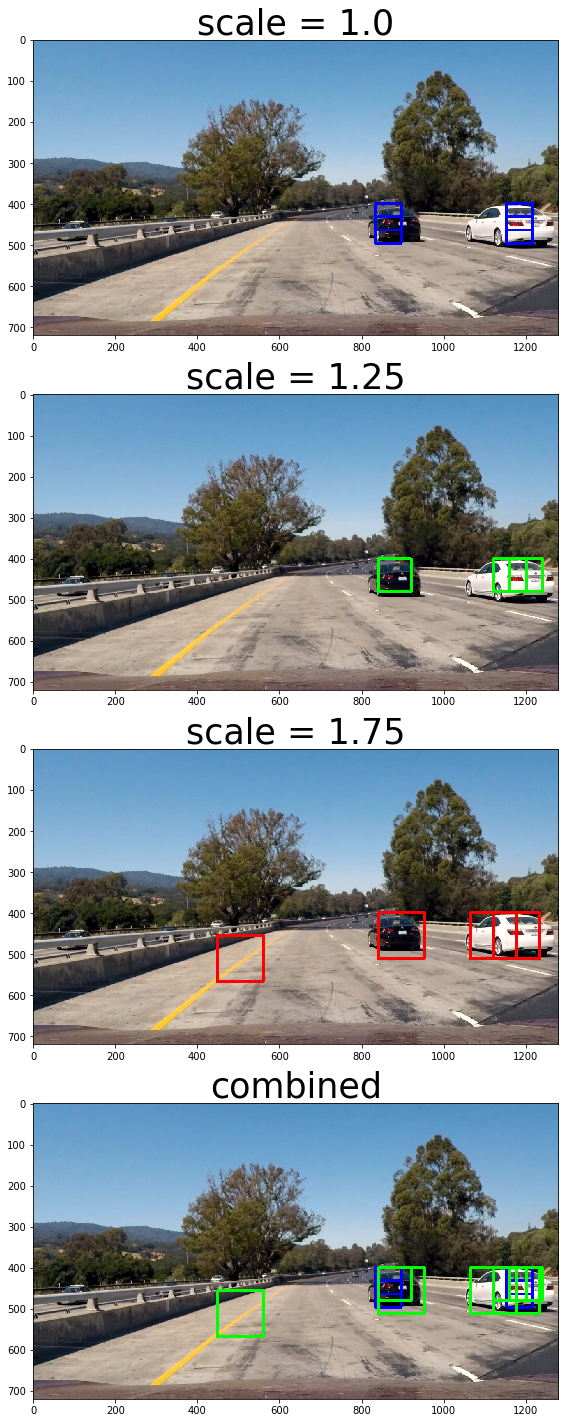

In [52]:
detection_1 = find_cars(img_test, scale=1.0, X_scaler=X_scaler_2, orient=11, pix_per_cell=16, cell_per_block=2, hog_channel='ALL', cspace='YUV')
test_still_1 = draw_boxes(img_test, detection_1, color=(0,0,255), thick=6)
detection_2 = find_cars(img_test, scale=1.25, X_scaler=X_scaler_2, orient=11, pix_per_cell=16, cell_per_block=2, hog_channel='ALL', cspace='YUV')
test_still_2 = draw_boxes(img_test, detection_2, color=(0,255,0), thick=6)
detection_3 = find_cars(img_test, scale=1.75, X_scaler=X_scaler_2, orient=11, pix_per_cell=16, cell_per_block=2, hog_channel='ALL', cspace='YUV')
test_still_3 = draw_boxes(img_test, detection_3, color=(255,0,0), thick=6)
# combine three images:
combined_img = draw_boxes(test_still_1, detection_2, color=(0,255,0), thick=6)
combined_img = draw_boxes(combined_img, detection_3, color=(0,255,0), thick=6)

# plot
fig, ax = plt.subplots(4,1,figsize=(25,25))
ax.flat[0].imshow(test_still_1)
ax.flat[0].set_title('scale = 1.0',fontsize=35)
ax.flat[1].imshow(test_still_2)
ax.flat[1].set_title('scale = 1.25',fontsize=35)
ax.flat[2].imshow(test_still_3)
ax.flat[2].set_title('scale = 1.75',fontsize=35)
ax.flat[3].imshow(combined_img)
ax.flat[3].set_title('combined',fontsize=35)

### Add in a heat map to filter out false positives
#### steps to adding heat map filter:
1. Take a zero data image of identical size to the video frame, add 1 for each time the region is confirmed positive
2. Apply a threshold to filter everything that is below the threshold
3. Use label function to determine the number of cars found
4. Redraw boxes on region that are above the threshold

In [23]:
# function to "add heat"
def add_heat(heatmap, bbox_list):
    for detection in bbox_list:
        for box in detection:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

# function for thresholding
def apply_threshold(heatmap, threshold):
    heatmap[heatmap<=threshold] = 0
    return heatmap

# function redraw boxes regions where positives are confirmed
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

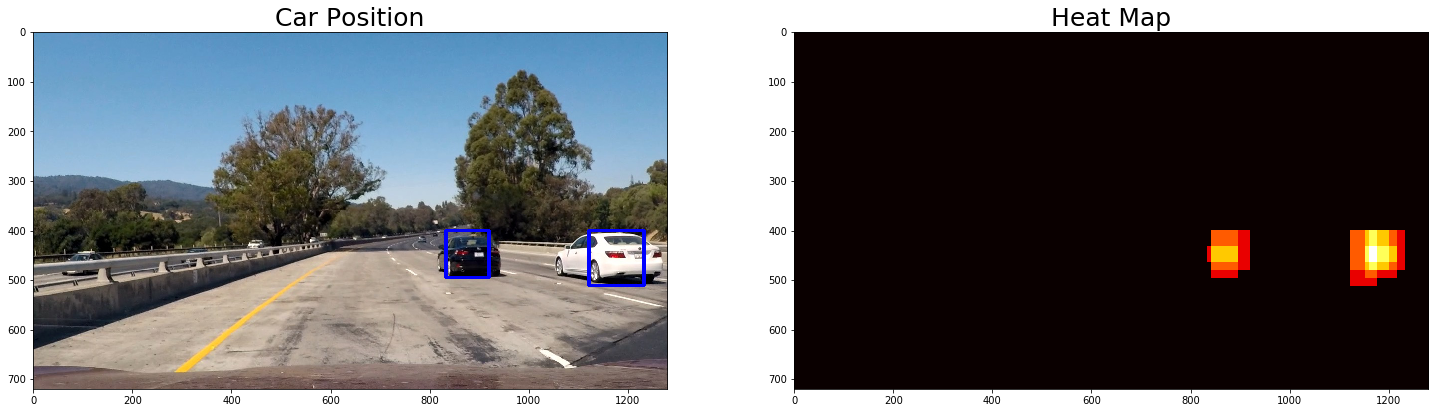

In [53]:
# testing heat map filter on the image above
# storing the positive points in an array
bbox_list = [detection_1, detection_2, detection_3]

heatmap = np.zeros_like(img_test[:,:,0])
heat = add_heat(heatmap,bbox_list)
heat = apply_threshold(heat,1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img_test), labels)
# visualize
fig, ax = plt.subplots(1,2, figsize=(25,25))
ax.flat[0].imshow(draw_img)
ax.flat[0].set_title('Car Position',fontsize=25)
ax.flat[1].imshow(heatmap, cmap='hot')
ax.flat[1].set_title('Heat Map', fontsize=25)

## Implement pipeline on video

In [25]:
# load in classifier
import pickle
f = open('trained_clf2.p', 'rb')
clf2 = pickle.load(f)
f.close()

In [46]:
# a final pipeline to tie everything together to produce a processed, color image
def process_image(img):
    # obtain possible matches with different scales
    detection_1 = find_cars(img, scale=1.0, X_scaler=X_scaler_2, orient=11, pix_per_cell=16, cell_per_block=2, hog_channel='ALL', cspace='YUV')
    detection_2 = find_cars(img, scale=1.25, X_scaler=X_scaler_2, orient=11, pix_per_cell=16, cell_per_block=2, hog_channel='ALL', cspace='YUV')
    detection_3 = find_cars(img, scale=1.75, X_scaler=X_scaler_2, orient=11, pix_per_cell=16, cell_per_block=2, hog_channel='ALL', cspace='YUV')
    bbox_list = [detection_1, detection_2, detection_3]
    # create heat map to later use as a filter to eliminate false positives
    heatmap = np.zeros_like(img[:,:,0])
    heat = add_heat(heatmap,bbox_list)
    heat = apply_threshold(heat,2)
    #heatmap = np.clip(heat, 0, 255)
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [55]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# create a Line instance for left and right line:
white_output = "project_video_processed3.mp4"
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_processed3.mp4
[MoviePy] Writing video project_video_processed3.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [42:48<00:02,  2.05s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed3.mp4 

Wall time: 42min 49s
